# 15장 심층 합성곱 신경망으로 이미지 분류

이 장에서는 합성곱 신경망을 배우고 텐서플로에서 CNN을 구현하는 방법을 알아보겠습니다.

## 15.1 합성곱 신경망의 구성 요소

### 15.1.1 CNN과 특성 계층 학습

다층 신경망과 특히 심층 합성곱 신경망은 각 층별로 저수준 특성을 연결하여 고수준 특성을 만듦으로써 소위 특성 계층을 구성합니다. 예를 들어 이미지를 다룬다면 에지(edge)나 동그라미 같은 저수준 특성이 
앞쪽 층에서 추출됩니다. 이 특성들이 연결되어 건물, 자동차, 강아지 같은 고수준 특성을 형성합니다.

CNN은 일반적으로 이미지 관련 작업을 매우 잘 수행하는데 다음 두개의 중요한 아이디어 때문입니다.

* 희소 연결: 특성 맵에 있는 하나의 원소는 작은 픽셀 패치 하나에만 연결됩니다.
* 파라미터 공유: 동일한 가중치가 입력 이미지의 모든 패치에 사용됩니다.

이 두 아이디어의 결과로 네트워크의 가중치 개수가 극적으로 감소하고 중요한 특징을 잡아내는 능력이 향상됩니다. 당연히 가까이 있는 픽셀들이 멀리 떨어져 있는 픽셀보다 연관성이 높습니다.

일반적으로 CNN은 여러 개의 합성곱(conv) 층과 풀링(Pooling)이라고 하는 서브샘플링(subsampling)층으로 이루어져 있습니다. 마지막에는 하나 이상의 완전 연결(FC)층이 따라옵니다. 완전 연결 층은 모든 입력 유닛 i가 모든 출력 유닛j에 가중치 w_ij로 연결되어 있는 다층 퍼셉트론입니다.

풀링 층(pooling layer)으로 알려진 서브 샘플링 층은 학습되는 파라미터가 없습니다. 즉 풀링 층에는 가중치나 절편 유닛이 없습니다. 합성곱이나 완전 연결 층은 가중치와 절편을 가집니다.

### 15.1.2 이산 합성곱 수행

#### 합성곱에서 제로 패딩의 효과

실전에서 자주 사용하는 세 개의 패딩 방법은 풀(full)패딩, 세임(same)패딩, 밸리드(valid)패딩 입니다.

* 풀 패딩은 패딩 파리미터 p를 p=m-1로 설정합니다. 풀 패딩은 출력 크기를 증가시키기 때문에 합성곱 신경망 구조에서는 거의 사용되지 않습니다.
* 세임 패딩은 출력 크기가 입력 벡터 x와 같아야 할 때 사용합니다. 이때 패딩 파라미터 p는 입력과 출력의 크기가 동일해야 하기 때문에 필터 크기에 따라 결정됩니다.
* 마지막으로 밸리드 패딩 합성곱은 p=0인 경우를 말합니다(패딩 없음)

실전에서는 세임 패딩으로 너비와 높이를 유지시키고 풀링에서 크기를 감소시킵니다. 풀 패딩은 입력보다 출력 크기를 증가시키므로 경계 부분의 영향을 최소화하는 것이 중요한 신호처리 애플리케이션에서 보통 사용됩니다.

In [1]:
## 1차원 합성곱 구현

import numpy as np

## s: step, p: padding
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])

    res = []

    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))

    return np.array(res)



In [2]:
x = [1,3,2,4,5,6,1,3]
w = [1,0,3,1,2]

print('Conv1d 구현:', conv1d(x, w, p=2, s=1))
print('넘파이 결과:', np.convolve(x, w, mode='same'))

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


In [3]:
## 2차원 합성곱 구현

import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])

        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))

    return(np.array(res))

In [4]:
X = [[1,3,2,4], [5,6,1,3], [1,2,0,2], [3,4,3,2]]
W = [[1,0,3], [1,2,1], [0,1,1]]

In [5]:
print('Conv2d 구현: \n', conv2d(X, W, p=(1,1), s=(1,1)))
print('사이파이 결과:\n', scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현: 
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
사이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### 15.1.3 서브샘플링

서브샘플링은 전형적인 두 종류의 풀링 연산으로 합성곱 신경망에 적용됩니다. 최대 풀링과 평균 풀링 입니다.
최대 풀링은 이웃한 픽셀에서 최댓값을 취하고 평균 풀링은 픽셀의 평균을 계산합니다.

풀링의 장점은 두 가지 입니다.
*풀링(최대 풀링)은 일종의 지역 불변성을 만듭니다. 국부적인 작은 변화가 최대 풀링의 결과를 바꾸지 못한다는 의미입니다. 결국 입력 데이터에 있는 잡음에 좀 더 안정적인 특성을 생성합니다.
* 풀링은 특성 크기를 줄이므로 계산 효율성을 높입니다. 또 특성 개수가 줄어들면 과대적합도 감소됩니다.


## 15.2 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 15.2.1 여러 개의 입력 또는 컬러 채널 다루기



In [2]:
import imageio
img = imageio.imread('./image/example-image.png', pilmode='RGB')
print('이미지 크기:', img.shape)
print('채널 수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 수: 3
이미지 데이터 타입: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


### 15.2.2 드롭아웃으로 신경망 구제

드롭아웃은 신경망을 규제하는 데 매우 뛰어납니다. 예측을 할 때는 훈련된 모델을 모두 사용하여 결정합니다. 여러 개의 모델을 훈련하고 출력을 모아 평균을 내는 작업은 계산 비용이 비쌉니다. 드롭아웃은 많은 모델을 동시에 훈련하고 테스트나 예측 시에 평균을 효율적으로 계산하는 효과적인 방법을 제공합니다.

보통 드롭아웃은 깊은 층의 은닉 유닛에 적용합니다. 신경망의 훈련 단계에서 반복마다 확률적으로 은닉 유닛의 일부가 랜덤하게 꺼집니다. 입력 뉴런의 일부를 끄면 남은 뉴런에 연결된 가중치가 누락된 뉴런 비율만큼 증가합니다.

랜덤한 드롭아웃은 네트워크가 데이터에서 더 일반적이고 안정적인 패턴을 학습하게 만듭니다. 결과적으로 과대적합을 방지하는 효과를 볼 수 있습니다.

## 15.3 텐서플로를 사용하여 심층 합성곱 신경망 구현

### 15.3.1 다층 CNN 구조

In [5]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols =struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

In [6]:
### 15.3.2 데이터 적재와 전처리

X_data, y_data = load_mnist('./mnist/', kind='train')
print('행: {}, 열: {}'.format(X_data.shape[0], X_data.shape[1]))

X_test, y_test = load_mnist('./mnist/', kind='t10k')
print('행: {}, 열: {}'.format(X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('훈련 세트: ', X_train.shape, y_train.shape)
print('검증 세트: ', X_valid.shape, y_valid.shape)
print('테스트 세트: ', X_test.shape, y_test.shape)

행: 60000, 열: 784
행: 10000, 열: 784
훈련 세트:  (50000, 784) (50000,)
검증 세트:  (10000, 784) (10000,)
테스트 세트:  (10000, 784) (10000,)


In [7]:
## 훈련 성능을 높이고 최적 값에 잘 수렴하게 하기 위한 데이터 정규화 과정

mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

In [8]:
## numpy의 reshape 메서드를 이용한 데이터 차원 변경

X_train_centered = X_train_centered.reshape((-1, 28, 28, 1))
X_valid_centered = X_valid_centered.reshape((-1, 28, 28, 1))
X_test_centered = X_test_centered.reshape((-1, 28, 28, 1))

In [9]:
## 원-핫 인코딩

from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

print(y_train[0], y_train_onehot)

5 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [10]:
## 변경된 크기 출력

print('훈련 세트: ', X_train_centered.shape, y_train_onehot.shape)
print('검증 세트: ', X_valid_centered.shape, y_valid_onehot.shape)
print('테스트 세트: ', X_test_centered.shape, y_test_onehot.shape)

훈련 세트:  (50000, 28, 28, 1) (50000, 10)
검증 세트:  (10000, 28, 28, 1) (10000, 10)
테스트 세트:  (10000, 28, 28, 1) (10000, 10)


### 15.3.3 텐서플로 tf.keras API로 CNN 구성

In [11]:
from tensorflow.keras import layers, models

model = models.Sequential()

# Conv2D 클래스 추가
model.add(layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 1)))
# 최대 풀링 층
model.add(layers.MaxPool2D((2, 2)))
# 두 번째 합성곱 층 추가
model.add(layers.Conv2D(64, (5, 5), padding='valid', activation='relu'))
# 두 번째 풀링층 추가
model.add(layers.MaxPool2D((2, 2)))
# 맵의 차원을 일렬로 펼치기 -> 1024 차원의 텐서로 됨
model.add(layers.Flatten())
# 완전 연결층 연결
model.add(layers.Dense(1024, activation='relu'))
# 드롭아웃 추가
model.add(layers.Dropout(0.5))
# 확률 출력을 위한 활성화층 추가
model.add(layers.Dense(10, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [16]:
### 15.3.4 합성곱 신경망 훈련

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# 체크포인트 콜백은 검증 손실을 모니터링 하고 최상의 가중치를 cnn_checkpoint.h5파일에 저장합니다

callback_list = [ModelCheckpoint(filepath='cnn_checkpoint.h5', monitor='val_loss', save_best_only=True), TensorBoard(log_dir="logs/{}".format(time.asctime()))]

In [19]:
history = model.fit(X_train_centered, y_train_onehot, 
    batch_size=64, epochs=20, 
    validation_data=(X_valid_centered, y_valid_onehot))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 38s 767us/sample - loss: 0.1411 - acc: 0.9566 - val_loss: 0.0507 - val_acc: 0.9848
Epoch 2/20
50000/50000 [==============================] - 34s 684us/sample - loss: 0.0496 - acc: 0.9846 - val_loss: 0.0420 - val_acc: 0.9876
Epoch 3/20
50000/50000 [==============================] - 36s 713us/sample - loss: 0.0354 - acc: 0.9897 - val_loss: 0.0337 - val_acc: 0.9901
Epoch 4/20
50000/50000 [==============================] - 47s 940us/sample - loss: 0.0288 - acc: 0.9908 - val_loss: 0.0401 - val_acc: 0.9894
Epoch 5/20
50000/50000 [==============================] - 49s 974us/sample - loss: 0.0233 - acc: 0.9929 - val_loss: 0.0451 - val_acc: 0.9891
Epoch 6/20
50000/50000 [==============================] - 44s 877us/sample - loss: 0.0204 - acc: 0.9935 - val_loss: 0.0389 - val_acc: 0.9908
Epoch 7/20
50000/50000 [==============================] - 49s 971us/sample - loss: 0.0181 - acc: 0.9946 

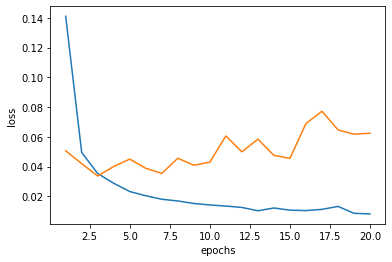

In [20]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 21)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

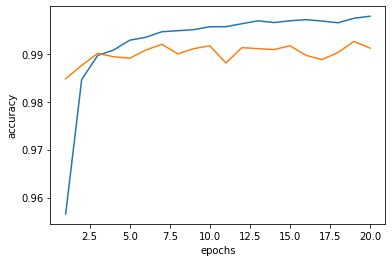

In [21]:
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [22]:
## 가중치 저장 및 복원

model.save('cnn_model.h5')

In [23]:
# from tensorflow.keras.models import load_model

# restored_model = load_model('cnn_model.h5')
# restored_model.load_weights('cnn_check')

In [31]:
# 체크포인트 콜백은 검증 손실을 모니터링 하고 최상의 가중치를 cnn_checkpoint.h5파일에 저장합니다

callback_list = [ModelCheckpoint(filepath='cnn_checkpoint.h5', monitor='val_loss', save_best_only=True), TensorBoard(log_dir="logs\\{}".format(time.strftime('%Y-%m-%d-%H_%M_%S')))]

history2 = model.fit(X_train_centered, y_train_onehot, 
    batch_size=64, epochs=20, 
    validation_data=(X_valid_centered, y_valid_onehot),
    callbacks=callback_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 33s 666us/sample - loss: 0.0114 - acc: 0.9970 - val_loss: 0.0695 - val_acc: 0.9909
Epoch 2/20
50000/50000 [==============================] - 35s 690us/sample - loss: 0.0099 - acc: 0.9977 - val_loss: 0.0752 - val_acc: 0.9922
Epoch 3/20
50000/50000 [==============================] - 35s 704us/sample - loss: 0.0108 - acc: 0.9978 - val_loss: 0.0787 - val_acc: 0.9909
Epoch 4/20
50000/50000 [==============================] - 35s 705us/sample - loss: 0.0107 - acc: 0.9978 - val_loss: 0.0835 - val_acc: 0.9921
Epoch 5/20
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0111 - acc: 0.9978 - val_loss: 0.0879 - val_acc: 0.9915
Epoch 6/20
50000/50000 [==============================] - 36s 723us/sample - loss: 0.0109 - acc: 0.9976 - val_loss: 0.0877 - val_acc: 0.9909
Epoch 7/20
50000/50000 [==============================] - 38s 752us/sample - loss: 0.0088 - acc: 0.9980 

In [27]:
time.strftime('%Y-%m-%d-%H_%M_%S')

'2020-07-12-14_24_39'